# **<font color='crimson'>«Расчет среднего времени ответа менеджеров службы поддержки»</font>**

---

**Выполнил**: Юмаев Егор

---

## <font color='green'>**ПОСТАНОВКА ЗАДАЧИ**</font>

---

В базе данных Отдела продаж имеются сведения об ответах менеджеров в сделках в amoCRM. Под **сделкой** подразумевается серия сообщений в рамках переписки по обращению каждого клиента.

**Задача**: с помощью SQL-запроса к базе данных (**PostgresSQL**) необходимо рассчитать среднее время ответа для каждого менеджера (пары менеджеров).


Должны быть учтены следующие моменты:

* **(1)** Если в диалоге идут несколько сообщений подряд от клиента или менеджера, то при расчёте времени ответа надо учитывать только первое сообщение из каждого блока.

* **(2)** Менеджеры работают с 09:30 до 00:00, поэтому нерабочее время не должно учитываться в расчёте среднего времени ответа, т.е. если клиент написал в 23:59, а менеджер ответил в 09:30 – время ответа равно одной минуте.

* **(3)** Ответы на сообщения, пришедшие, ночью также нужно учитывать.


Исходя из тех задания, ответы на сообщения, пришедшие ночью, следует учитывать. Однако, т.к. рабочее время менеджера с 9:30 до 00:00, если ответ был дан в нерабочее время, такой ответ не будет учтен при расчете среднего времени по двум причинам:

* **Причина 1**: организация не оплачивает работу менеджера за пределами установленного графика рабочего времени, следовательно, ответы менеджера в это время – исключительно его инициатива.

* **Причина 2**: если менеджер по своей инициативе отвечает на сообщения клиентов в нерабочее время, он объективно не стремится делать это максимально быстро, как в рабочие часы. Т.к. и без того менеджер выполняет трудовые обязанности в свое личное время, будет несправедливо ухудшать его показатель, учитывая более длительные периоды ответов на сообщения.


Таким образом, будут учитываться ответы на сообщения, пришедшие ночью в нерабочее время, в том случае, если ответ на них менеджер дал в рабочее время.

Для решения поставленной задачи из базы данных необходимо использовать следующие таблицы:

* **test.chat_messages** - содержит данные о входящих и исходящих сообщениях внутри сделок.

* **test.managers** - содержит данные о менеджерах.

* **test.rops** - содержит данные о руководителях Отдела продаж.


## <font color='green'>**ПОДКЛЮЧЕНИЕ К БАЗЕ ДАННЫХ И EDA ТАБЛИЦ**</font>

---

In [27]:
# импортируем необходимые библиотеки
import psycopg2
import pandas as pd

In [28]:
# устанавливаем подключение к базе данных PostgreSQL,
# размещенной на удаленном сервере
try:
    connection = psycopg2.connect(
        host="rc1a-p8bp15mmxsfwpbt0.mdb.yandexcloud.net",
        port="6432",
        database="db1",
        user="test_user",
        password="j2M{CnnFq@"
    )
    cursor = connection.cursor()
    print("Connection established successfully!")
except Exception as e:
    print("Error connecting to the database:", e)

Connection established successfully!


In [29]:
# задаем функцию для получения данных из базы данных PostgreSQL
def select(sql, columns = None):
    try:
        cursor.execute(sql)
        results = cursor.fetchall()
        results = pd.DataFrame(
            results).reset_index(drop = True)
        if columns:
            results.columns = columns
        return results
    except Exception as e:
        print("Error executing the query:", e)

In [4]:
# создадим списки с названиями признаков таблиц
cols_chat = [
    'message_id', 'type', 'entity_id', 'created_by', 'created_at'
]

cols_managers = [
    'mop_id', 'name_mop', 'rop_id'
]

cols_rops = ['rop_id', 'rop_name']

Посчитаем количество записей в таблице **test.chat_messages**.

In [ ]:
sql = '''
    SELECT
        COUNT(1) AS number_of_rows
    FROM
        test.chat_messages
    ;
'''

In [ ]:
select(sql, ['number_of_rows'])

,number_of_rows
0,18929


Выведем первые 10 строк таблицы **test.chat_messages**.

In [ ]:
sql = '''
    SELECT *
    FROM
        test.chat_messages
    LIMIT 10
    ;
'''

In [ ]:
select(sql, cols_chat)

,message_id,type,entity_id,created_by,created_at
0,"""01jb7da570sf4f65xdf0ptvv9q""",incoming_chat_message,37556493,0,1730046924
1,"""01jb3t6bc8gvyfnd063nd91ng4""",incoming_chat_message,37549491,0,1729926213
2,"""01jb6gj9ngwk0ybbmg9w90pbqg""",incoming_chat_message,37531455,0,1730016782
3,"""01jb75bkprk0d7hht1g5vy1pm4""",incoming_chat_message,37553371,0,1730038583
4,"""01jb3t5xprbph1c6pym8ervxpm""",incoming_chat_message,37548675,0,1729926199
5,"""01jb478n40pk0c0v1zsk3wtwfr""",incoming_chat_message,37550015,0,1729939920
6,"""01jb3t5vr8rfzv8j2ny519nqzk""",incoming_chat_message,37427859,0,1729926197
7,"""01jb3z6s5gv240x8qg8kj8927v""",incoming_chat_message,37054671,0,1729931470
8,"""01jb3t5rtg6s3eks367rm33rb0""",incoming_chat_message,37546971,0,1729926194
9,"""01jb3t5rtghb56gcbvktr7txx5""",incoming_chat_message,37549489,0,1729926194


Посчитаем число уникальных сделок.

In [ ]:
sql = '''
    SELECT
        COUNT(DISTINCT t.entity_id) AS number_entity_unique
    FROM
        test.chat_messages AS t
    ;
'''

In [ ]:
select(sql, ['number_entity_unique'])

,number_entity_unique
0,3544


На одну сделку приходится примерно шесть сообщений.

Проверим, какое количество сообщений было написано от клиентов.

In [25]:
sql = '''
    WITH subquery AS (
        SELECT COUNT(1) AS num_of_rows
        FROM test.chat_messages
    )

    SELECT
        COUNT(1) AS number_client_messages
        ,ROUND(
            COUNT(1) * 1. / (SELECT t.num_of_rows FROM subquery AS t) * 100, 2)
            AS part_of_client_messages
    FROM
        test.chat_messages AS t
    WHERE t.created_by IN (0)
    GROUP BY
        t.created_by
    ;
'''

In [26]:
select(sql, [
    'number_client_messages',
    'part_of_client_messages'
])

,number_client_messages,part_of_client_messages
0,10313,54.48


Доля сообщений клиентов превышает долю сообщений менеджеров: 54.5% против 44.5%. Можно предположить, что:

* (1) либо клиенты описывают свою ситуацию более, чем одним сообщением

* (2) либо клиенты благодарят менеджеров за решенный вопрос, но менеджеры не пишут финальное сообщение вроде 'Если возникнут вопросы - всегда рады вам помочь' и т.п. Этот вопрос потребует дополнительного исследования.

Посчитаем количество уникальных идентификаторов менеджеров.

In [ ]:
sql = '''
    SELECT
        COUNT(t.mop_id) AS num_of_managers
        ,COUNT(DISTINCT t.mop_id) AS num_unique_of_managers
    FROM
        test.managers AS t
    ;
'''

In [ ]:
select(sql, [
    'num_of_managers',
    'num_unique_of_managers'
])

,num_of_managers,num_unique_of_managers
0,26,26


Количество менеджеров, отвечающих на сообщения клиентов - 26.

Выведем информацию о менеджерах.

In [ ]:
sql = '''
    SELECT *
    FROM test.managers
    ;
'''

In [ ]:
select(sql, cols_managers)

,mop_id,name_mop,rop_id
0,6645315,Гюнель и Илина,1
1,6744792,Юля и Наташа,1
2,10262505,Вика и Марго,1
3,10262513,Ира и Варя,1
4,10465254,Настя и Даша,1
5,11448610,Вика и Катя,1
6,11490270,Аня и Ксюша,1
7,11490278,Ксюша и Джамиля,1
8,6780177,Даша и Даша,2
9,7436430,Софа и Алина,2


Информация об имени менеджера **7408332** не внесена в таблицу. Возможно, это техническая ошибка. Посчитаем количество сообщений, котоыре написал менеджер с id **7408332**.

In [ ]:
sql = '''
    SELECT COUNT(1) AS messages_count
    FROM test.chat_messages AS t
    WHERE created_by IN (7408332)
    ;
'''

In [ ]:
select(sql, ['messages_count'])

,messages_count
0,0


Клиент с неуказанным именем не писал сообщений. Для проводимого анализа это значение не имеет. Видимо, менеджер сменил место работы, но его id еще не был убран из базы.

Выведем сведения о руководителях отдела продаж.

In [ ]:
sql = '''
    SELECT * FROM test.rops
    ;
'''

In [ ]:
select(sql, cols_rops)

,rop_id,rop_name
0,1,Катя РОП
1,2,Полина РОП
2,3,Эля РОП


Общие сведения о базе данных получены.

## <font color='green'>**РАСЧЕТ СРЕДНЕГО ВРЕМЕНИ ОТВЕТА МЕНЕДЖЕРА**</font>

---

Проверим, есть ли сделки, по которым число сообщений равно 0 или 1.

In [ ]:
sql = '''
    SELECT
        t.entity_id
        ,COUNT(1) AS number_of_messages
    FROM
        test.chat_messages AS t
    GROUP BY
        t.entity_id
    ORDER BY
        COUNT(1) ASC
    LIMIT 5
    ;
'''

In [ ]:
select(sql, ['entity_id', 'number_of_messages'])

,entity_id,number_of_messages
0,37549971,1
1,37552001,1
2,37556649,1
3,37552501,1
4,37551359,1


Сделки со всего одним сообщением есть, и они не являются предметом анализа. Их необходимо отфильтровать из таблицы.

In [ ]:
sql = '''
WITH subquery AS (
    SELECT
         t.*
         ,COUNT(1) OVER (PARTITION BY t.entity_id) AS number_of_messages
    FROM
        test.chat_messages AS t
)
    SELECT
        t.*
        ,COUNT(1) OVER()
    FROM
        subquery AS t
    WHERE
        t.number_of_messages > 1
    LIMIT 5
    ;
'''

In [ ]:
select(sql, cols_chat + ['number_of_messages', 'count'])

,message_id,type,entity_id,created_by,created_at,number_of_messages,count
0,"""01jb4qj2skc2wjfdm8qaf69yjh""",outgoing_chat_message,35810509,10262493,1729957006,4,16995
1,"""01jb4qedfgxnd2yqr4w26hs4q5""",incoming_chat_message,35810509,0,1729956886,4,16995
2,"""01jb4pjb1g22ts7z6arcjv11w6""",incoming_chat_message,35810509,0,1729955966,4,16995
3,"""01jb4pncn7gm1re1zdxkzhnp6s""",outgoing_chat_message,35810509,10262493,1729956065,4,16995
4,"""01jb7h4ad8weqjx1ynrh7s8k25""",outgoing_chat_message,35945535,10262493,1730050927,2,16995


Вероятно, многие входящие запросы являются спамом, поэтому менеджеры на них не отвечают. Позже вернемся к этому запросу, который отфильтровывает все сделки с единственным сообщением.

Для предварительного анализа отберем сделку, по которой было порядка 20 сообщений. На этой сделке будет протестирован запрос, который не будет нагружать базу данных излишними вычислениями и позволит провести отладку кода.

In [ ]:
sql = '''
    SELECT
        t.entity_id
        ,COUNT(1) AS number_of_messages
    FROM
        test.chat_messages AS t
    GROUP BY
        t.entity_id
    ORDER BY
        COUNT(1) DESC
    LIMIT 5
    OFFSET 250
    ;
'''

In [ ]:
select(sql, ['entity_id', 'number_of_messages'])

,entity_id,number_of_messages
0,37511647,20
1,37546935,20
2,37515333,20
3,37552989,20
4,37518259,20


Выберем для предварительного анализа сделку № **37515333**.

В таблице  **test.chat_messages** изменим тип данных столбца **created_at** c **Timestamp** на **Date**.

In [ ]:
sql = '''
-- в таблице test.chat_messages изменим
-- тип данных столбца created_at c Timestamp на Date
    SELECT
        t.message_id
        ,t.type
        ,t.entity_id
        ,t.created_by
        ,TO_TIMESTAMP(
            t.created_at) AS created_at
    FROM
        test.chat_messages AS t
    WHERE
        t.entity_id IN (37546935)
    ORDER BY
        TO_TIMESTAMP(t.created_at) ASC
    LIMIT 4
    ;
'''

In [ ]:
select(sql, cols_chat)

,message_id,type,entity_id,created_by,created_at
0,"""01jb47pbk824fmngymazv263sz""",incoming_chat_message,37546935,0,2024-10-26 13:59:29+03:00
1,"""01jb485j8vmtqeqw5wcqkc5z1t""",outgoing_chat_message,37546935,11448610,2024-10-26 14:07:47+03:00
2,"""01jb4883yr4vkte5c5zmd8v2e2""",incoming_chat_message,37546935,0,2024-10-26 14:09:11+03:00
3,"""01jb48v4verte3yd1hd1k94max""",outgoing_chat_message,37546935,11448610,2024-10-26 14:19:34+03:00


С помощью окононной функции для каждого ответа менеджера укажем время, в которое клиент написал сообщение.

In [ ]:
sql = '''
-- в таблице test.chat_messages изменим
-- тип данных столбца created_at c Timestamp на Date
WITH subquery AS (
    SELECT
        t.message_id
        ,t.type
        ,t.entity_id
        ,t.created_by
        ,TO_TIMESTAMP(
            t.created_at) AS created_at
    FROM
        test.chat_messages AS t
    WHERE
        t.entity_id IN (37546935)
    ORDER BY
        TO_TIMESTAMP(t.created_at) ASC
)
-- с помощью окононной функции для каждого ответа менеджера укажем время,
-- в которое клиент написал сообщение
SELECT
    t.*
    ,LAG(
        t.created_at, 1) OVER (
            PARTITION BY t.entity_id
            ORDER BY t.created_at) AS client_order_time
FROM
    subquery AS t
LIMIT 8
    ;
'''

In [ ]:
select(sql, cols_chat + ['client_order_time'])

,message_id,type,entity_id,created_by,created_at,client_order_time
0,"""01jb47pbk824fmngymazv263sz""",incoming_chat_message,37546935,0,2024-10-26 13:59:29+03:00,NaT
1,"""01jb485j8vmtqeqw5wcqkc5z1t""",outgoing_chat_message,37546935,11448610,2024-10-26 14:07:47+03:00,2024-10-26 13:59:29+03:00
2,"""01jb4883yr4vkte5c5zmd8v2e2""",incoming_chat_message,37546935,0,2024-10-26 14:09:11+03:00,2024-10-26 14:07:47+03:00
3,"""01jb48v4verte3yd1hd1k94max""",outgoing_chat_message,37546935,11448610,2024-10-26 14:19:34+03:00,2024-10-26 14:09:11+03:00
4,"""01jb4aqvq0pezm6bf2hh4bkrem""",incoming_chat_message,37546935,0,2024-10-26 14:52:44+03:00,2024-10-26 14:19:34+03:00
5,"""01jb4axzhgceqhd669jhdarscf""",outgoing_chat_message,37546935,11448610,2024-10-26 14:56:04+03:00,2024-10-26 14:52:44+03:00
6,"""01jb4bp2gg95br5mbhzgeygz4m""",incoming_chat_message,37546935,0,2024-10-26 15:09:14+03:00,2024-10-26 14:56:04+03:00
7,"""01jb4c0fjw9f3x8qq3728y95wd""",outgoing_chat_message,37546935,11448610,2024-10-26 15:14:55+03:00,2024-10-26 15:09:14+03:00


Отфильтруем из таблицы все строки, относящиеся к клиентам - для расчета среднего времени ответа менеджера они более не требуются.

In [ ]:
sql = '''
-- в таблице test.chat_messages изменим
-- тип данных столбца created_at c Timestamp на Date
WITH subquery AS (
    SELECT
        t.message_id
        ,t.type
        ,t.entity_id
        ,t.created_by
        ,TO_TIMESTAMP(
            t.created_at) AS created_at
    FROM
        test.chat_messages AS t
    WHERE
        t.entity_id IN (37546935)
    ORDER BY
        TO_TIMESTAMP(t.created_at) ASC
),
-- с помощью окононной функции для каждого ответа менеджера укажем время,
-- в которое клиент написал сообщение
subquery_2 AS (
    SELECT
        t.*
        ,LAG(
            t.created_at, 1) OVER (
                PARTITION BY t.entity_id
                ORDER BY t.created_at) AS client_order_time
    FROM
        subquery AS t
)
-- отфильтруем из таблицы все строки, относящиеся к клиентам
SELECT
    t.entity_id
    ,t.created_by
    ,t.client_order_time
    ,t.created_at AS manager_answer_time
FROM
    subquery_2 AS t
WHERE
    t.created_by NOT IN (0)
    ;
'''

In [ ]:
select(sql, [
    'entity_id',
    'created_by',
    'client_order_time',
    'manager_answer_time'])

,entity_id,created_by,client_order_time,manager_answer_time
0,37546935,11448610,2024-10-26 13:59:29+03:00,2024-10-26 14:07:47+03:00
1,37546935,11448610,2024-10-26 14:09:11+03:00,2024-10-26 14:19:34+03:00
2,37546935,11448610,2024-10-26 14:52:44+03:00,2024-10-26 14:56:04+03:00
3,37546935,11448610,2024-10-26 15:09:14+03:00,2024-10-26 15:14:55+03:00
4,37546935,11448610,2024-10-26 15:22:47+03:00,2024-10-26 15:28:49+03:00
5,37546935,11448610,2024-10-26 15:31:33+03:00,2024-10-26 15:43:20+03:00
6,37546935,11448610,2024-10-27 09:11:01+03:00,2024-10-27 10:09:02+03:00
7,37546935,11448610,2024-10-27 10:14:00+03:00,2024-10-27 10:25:28+03:00
8,37546935,11448610,2024-10-27 10:36:40+03:00,2024-10-27 10:51:03+03:00
9,37546935,11448610,2024-10-27 21:19:16+03:00,2024-10-27 21:29:06+03:00


Рабочее время менеджеров длится с 9:30 до 0:00.

Согласно техзадания, если клиент написал вопрос в 23:59, а менеджер ответил в 9:30, время ответа принимается равным одной минуте.

Конечно, подавляющая часть вопросов клиентов и ответов менеджеров будут находиться в пределах одного и того же рабочего дня. Однако, может быть две ситуации, когда вопрос и ответ находятся в разных рабочих днях, или вопрос пришел в один и тот же календарный день, но до начала рабочего дня менеджера.

**Ситуация 1**

Вопрос пришел в 23:59, менеджер ответил в 9:30. Чтобы получить время ответа, равное 1 минуте, необходимо перевести время в секунды (в формате Unix Timestamp), вычесть из времени ответа в секундах время написнаия клиентом запроса и дополнительно отнять 34_200 секунд (9 часов 30 минут).

**Время ответа менеджера в секундах** - **Время отправки клиентом сообщения** - **34200**

**Ситуация 2**

Вопрос пришел в 1:30 текущего календарного дня, менеджер ответил в 9:35 в тот же календарный день (начало рабочего дня 9:30). В этом случае, чтобы получить время ответа менеджера, ноебходимо из переведенного в формат Unix Timestamp в секунды времени ответа менеджера вычесть время отправки клиентом сообщения и чтобы компенсирвоать нерабочую часть времени требуется вычесть 34_200 (число секунд в 9 часах 30 минутах) и прибавить из времени прихода сообщения от клиента количество часов * 60 мин. * 60 сек. + количество минут * 60 сек.

**Время ответа менеджера в секундах** - **Время отправки клиентом сообщения** - **34200** + **кол-во часов (клиент) * 60 мин. * 60 сек.** + **кол-во минут (клиент) * 60 сек.** + **кол-во секунд (клиент)**

На следующем шаге выделим из времени отправки сообщения клиента / менеджера день, час, минуты и секунды.

In [ ]:
sql = '''
-- в таблице test.chat_messages изменим
-- тип данных столбца created_at c Timestamp на Date
WITH subquery AS (
    SELECT
        t.message_id
        ,t.type
        ,t.entity_id
        ,t.created_by
        ,TO_TIMESTAMP(
            t.created_at) AS created_at
    FROM
        test.chat_messages AS t
    WHERE
        t.entity_id IN (37546935)
    ORDER BY
        TO_TIMESTAMP(t.created_at) ASC
),
-- с помощью окононной функции для каждого ответа менеджера укажем время,
-- в которое клиент написал сообщение
subquery_2 AS (
    SELECT
        t.*
        ,LAG(
            t.created_at, 1) OVER (
                PARTITION BY t.entity_id
                ORDER BY t.created_at) AS client_order_time
    FROM
        subquery AS t
),
-- отфильтруем из таблицы все строки, относящиеся к клиентам
subquery_3 AS (
    SELECT
        t.entity_id
        ,t.created_by
        ,t.client_order_time
        ,t.created_at AS manager_answer_time
    FROM
        subquery_2 AS t
    WHERE
        t.created_by NOT IN (0)
)
-- выделим из времени отправки сообщения клиента / менеджера
-- день, час, минуты и секунды
SELECT
    t.*
    ,EXTRACT(DAY FROM t.client_order_time) AS client_day
    ,EXTRACT(HOUR FROM t.client_order_time) AS client_hour
    ,EXTRACT(MINUTE FROM t.client_order_time) AS client_minute
    ,ROUND(EXTRACT(SECOND FROM t.client_order_time)) AS client_second
    ,EXTRACT(DAY FROM t.manager_answer_time) AS manager_day
    ,EXTRACT(HOUR FROM t.manager_answer_time) AS manager_hour
    ,EXTRACT(MINUTE FROM t.manager_answer_time) AS manager_minute
    ,ROUND(EXTRACT(SECOND FROM t.manager_answer_time)) AS manager_second
FROM
    subquery_3 AS t
    ;
'''

In [ ]:
select(sql, [
    'entity_id',
    'created_by',
    'client_order_time',
    'manager_answer_time',
    'client_day', 'client_hour', 'client_minute', 'client_second',
    'manager_day', 'manager_hour', 'manager_minute', 'manager_second',
])

,entity_id,created_by,client_order_time,manager_answer_time,client_day,client_hour,client_minute,client_second,manager_day,manager_hour,manager_minute,manager_second
0,37546935,11448610,2024-10-26 13:59:29+03:00,2024-10-26 14:07:47+03:00,26,13,59,29,26,14,7,47
1,37546935,11448610,2024-10-26 14:09:11+03:00,2024-10-26 14:19:34+03:00,26,14,9,11,26,14,19,34
2,37546935,11448610,2024-10-26 14:52:44+03:00,2024-10-26 14:56:04+03:00,26,14,52,44,26,14,56,4
3,37546935,11448610,2024-10-26 15:09:14+03:00,2024-10-26 15:14:55+03:00,26,15,9,14,26,15,14,55
4,37546935,11448610,2024-10-26 15:22:47+03:00,2024-10-26 15:28:49+03:00,26,15,22,47,26,15,28,49
5,37546935,11448610,2024-10-26 15:31:33+03:00,2024-10-26 15:43:20+03:00,26,15,31,33,26,15,43,20
6,37546935,11448610,2024-10-27 09:11:01+03:00,2024-10-27 10:09:02+03:00,27,9,11,1,27,10,9,2
7,37546935,11448610,2024-10-27 10:14:00+03:00,2024-10-27 10:25:28+03:00,27,10,14,0,27,10,25,28
8,37546935,11448610,2024-10-27 10:36:40+03:00,2024-10-27 10:51:03+03:00,27,10,36,40,27,10,51,3
9,37546935,11448610,2024-10-27 21:19:16+03:00,2024-10-27 21:29:06+03:00,27,21,19,16,27,21,29,6


Вычислим время в секундах, которое потребовалось менеджеру для ответа на соответствующий вопрос.

In [ ]:
sql = '''
-- в таблице test.chat_messages изменим
-- тип данных столбца created_at c Timestamp на Date
WITH subquery AS (
    SELECT
        t.message_id
        ,t.type
        ,t.entity_id
        ,t.created_by
        ,TO_TIMESTAMP(
            t.created_at) AS created_at
    FROM
        test.chat_messages AS t
    WHERE
        t.entity_id IN (37546935)
    ORDER BY
        TO_TIMESTAMP(t.created_at) ASC
),
-- с помощью окононной функции для каждого ответа менеджера укажем время,
-- в которое клиент написал сообщение
subquery_2 AS (
    SELECT
        t.*
        ,LAG(
            t.created_at, 1) OVER (
                PARTITION BY t.entity_id
                ORDER BY t.created_at) AS client_order_time
    FROM
        subquery AS t
),
-- отфильтруем из таблицы все строки, относящиеся к клиентам
subquery_3 AS (
    SELECT
        t.entity_id
        ,t.created_by
        ,t.client_order_time
        ,t.created_at AS manager_answer_time
    FROM
        subquery_2 AS t
    WHERE
        t.created_by NOT IN (0)
),
-- выделим из времени отправки сообщения клиента / менеджера
-- день, час, минуты и секунды
subquery_4 AS (
    SELECT
        t.*
        ,EXTRACT(DAY FROM t.client_order_time) AS client_day
        ,EXTRACT(HOUR FROM t.client_order_time) AS client_hour
        ,EXTRACT(MINUTE FROM t.client_order_time) AS client_minute
        ,ROUND(EXTRACT(SECOND FROM t.client_order_time)) AS client_second
        ,EXTRACT(DAY FROM t.manager_answer_time) AS manager_day
        ,EXTRACT(HOUR FROM t.manager_answer_time) AS manager_hour
        ,EXTRACT(MINUTE FROM t.manager_answer_time) AS manager_minute
        ,ROUND(EXTRACT(SECOND FROM t.manager_answer_time)) AS manager_second
    FROM
        subquery_3 AS t
)
-- вычислим время в секундах, которое потребовалось менеджеру (паре менеджеров)
-- для ответа на соответствующий вопрос
SELECT
    t.entity_id
    ,t.created_by
    ,CASE
    WHEN
        t.client_day <> t.manager_day
    THEN
        ROUND(
        EXTRACT(EPOCH FROM t.manager_answer_time) -
        EXTRACT(EPOCH FROM t.client_order_time)) - 34200
    WHEN
        t.client_hour BETWEEN 0 AND 8
        OR (t.client_hour IN (9) AND t.client_minute BETWEEN 0 AND 29)
    THEN
        (ROUND(
        EXTRACT(EPOCH FROM t.manager_answer_time)
        - EXTRACT(EPOCH FROM t.client_order_time))
        - 34200
        + t.client_hour * 60 * 60
        + t.client_minute * 60
        + t.client_second)
    ELSE
        ROUND(
        EXTRACT(EPOCH FROM t.manager_answer_time) -
        EXTRACT(EPOCH FROM t.client_order_time))
    END AS answer_time_seconds
FROM
    subquery_4 AS t
    ;
'''

In [ ]:
select(sql, [
    'entity_id',
    'created_by',
    'answer_time_seconds',
])

,entity_id,created_by,answer_time_seconds
0,37546935,11448610,498
1,37546935,11448610,623
2,37546935,11448610,200
3,37546935,11448610,341
4,37546935,11448610,362
5,37546935,11448610,707
6,37546935,11448610,2342
7,37546935,11448610,688
8,37546935,11448610,863
9,37546935,11448610,590


Тестовый код на основе сделки с id **37546935** написан, успешно отрабатывает. Теперь добавим в его начало код, отфильтровывающий все сделки с одним единственным сообщением (добавится два подзапроса), удалим условие фильтрации только сделки с id **37546935**, - чтобы запрос отрабатывал для всех сделок.

In [ ]:
sql = '''
-- с помощью оконной функции вычислим число сообщений
-- по каждой сделке
WITH subquery AS (
    SELECT
         t.*
         ,COUNT(1) OVER (PARTITION BY t.entity_id) AS number_of_messages
    FROM
        test.chat_messages AS t
),
-- отфильтруем (удалим) из таблицы все сделки,
-- число сообщений по которым составляет 1 (один)
subquery_2 AS (
    SELECT
        t.*
        ,COUNT(1) OVER()
    FROM
        subquery AS t
    WHERE
        t.number_of_messages > 1
),
-- в таблице test.chat_messages изменим
-- тип данных столбца created_at c Timestamp на Date
subquery_3 AS (
    SELECT
        t.message_id
        ,t.type
        ,t.entity_id
        ,t.created_by
        ,TO_TIMESTAMP(
            t.created_at) AS created_at
    FROM
        subquery_2 AS t
    ORDER BY
        TO_TIMESTAMP(t.created_at) ASC
),
-- с помощью окононной функции для каждого ответа менеджера укажем время,
-- в которое клиент написал сообщение
subquery_4 AS (
    SELECT
        t.*
        ,LAG(
            t.created_at, 1) OVER (
                PARTITION BY t.entity_id
                ORDER BY t.created_at) AS client_order_time
    FROM
        subquery_3 AS t
),
-- отфильтруем из таблицы все строки, относящиеся к клиентам
subquery_5 AS (
    SELECT
        t.entity_id
        ,t.created_by
        ,t.client_order_time
        ,t.created_at AS manager_answer_time
    FROM
        subquery_4 AS t
    WHERE
        t.created_by NOT IN (0)
),
-- выделим из времени отправки сообщения клиента / менеджера
-- день, час, минуты и секунды
subquery_6 AS (
    SELECT
        t.*
        ,EXTRACT(DAY FROM t.client_order_time) AS client_day
        ,EXTRACT(HOUR FROM t.client_order_time) AS client_hour
        ,EXTRACT(MINUTE FROM t.client_order_time) AS client_minute
        ,ROUND(EXTRACT(SECOND FROM t.client_order_time)) AS client_second
        ,EXTRACT(DAY FROM t.manager_answer_time) AS manager_day
        ,EXTRACT(HOUR FROM t.manager_answer_time) AS manager_hour
        ,EXTRACT(MINUTE FROM t.manager_answer_time) AS manager_minute
        ,ROUND(EXTRACT(SECOND FROM t.manager_answer_time)) AS manager_second
    FROM
        subquery_5 AS t
)
-- вычислим время в секундах, которое потребовалось менеджеру (паре менеджеров)
-- для ответа на соответствующий вопрос,
-- удалив сведения об ответах менеджеров, сделанных в нерабочее время
SELECT
    t.entity_id
    ,t.created_by
    ,CASE
    WHEN
        t.client_day <> t.manager_day
    THEN
        ROUND(
        EXTRACT(EPOCH FROM t.manager_answer_time) -
        EXTRACT(EPOCH FROM t.client_order_time)) - 34200
    WHEN
        t.client_hour BETWEEN 0 AND 8
        OR (t.client_hour IN (9) AND t.client_minute BETWEEN 0 AND 29)
    THEN
        (ROUND(
        EXTRACT(EPOCH FROM t.manager_answer_time)
        - EXTRACT(EPOCH FROM t.client_order_time))
        - 34200
        + t.client_hour * 60 * 60
        + t.client_minute * 60
        + t.client_second)
    ELSE
        ROUND(
        EXTRACT(EPOCH FROM t.manager_answer_time) -
        EXTRACT(EPOCH FROM t.client_order_time))
    END AS answer_time_seconds
FROM
    subquery_6 AS t
WHERE
    (t.manager_hour NOT BETWEEN 0 AND 8)
    OR (t.manager_hour IN (9) AND t.manager_minute BETWEEN 0 AND 29)
LIMIT 10 OFFSET 500
    ;
'''

In [ ]:
select(sql, [
    'entity_id',
    'created_by',
    'answer_time_seconds',
])

,entity_id,created_by,answer_time_seconds
0,37352727,6645315,61
1,37355721,11448610,404
2,37355721,11448610,623
3,37355721,11448610,779
4,37358743,10262493,646
5,37358743,10262493,104
6,37360063,10465254,31
7,37360063,10465254,32
8,37360063,10465254,161
9,37360063,10465254,42


С помощью оконной функции вычислим среднее время ответа каждого менеджера.

In [ ]:
sql = '''
-- с помощью оконной функции вычислим число сообщений
-- по каждой сделке
WITH subquery AS (
    SELECT
         t.*
         ,COUNT(1) OVER (PARTITION BY t.entity_id) AS number_of_messages
    FROM
        test.chat_messages AS t
),
-- отфильтруем (удалим) из таблицы все сделки,
-- число сообщений по которым составляет 1 (один)
subquery_2 AS (
    SELECT
        t.*
        ,COUNT(1) OVER()
    FROM
        subquery AS t
    WHERE
        t.number_of_messages > 1
),
-- в таблице test.chat_messages изменим
-- тип данных столбца created_at c Timestamp на Date
subquery_3 AS (
    SELECT
        t.message_id
        ,t.type
        ,t.entity_id
        ,t.created_by
        ,TO_TIMESTAMP(
            t.created_at) AS created_at
    FROM
        subquery_2 AS t
    ORDER BY
        TO_TIMESTAMP(t.created_at) ASC
),
-- с помощью окононной функции для каждого ответа менеджера укажем время,
-- в которое клиент написал сообщение
subquery_4 AS (
    SELECT
        t.*
        ,LAG(
            t.created_at, 1) OVER (
                PARTITION BY t.entity_id
                ORDER BY t.created_at) AS client_order_time
    FROM
        subquery_3 AS t
),
-- отфильтруем из таблицы все строки, относящиеся к клиентам
subquery_5 AS (
    SELECT
        t.entity_id
        ,t.created_by
        ,t.client_order_time
        ,t.created_at AS manager_answer_time
    FROM
        subquery_4 AS t
    WHERE
        t.created_by NOT IN (0)
),
-- выделим из времени отправки сообщения клиента / менеджера
-- день, час, минуты и секунды
subquery_6 AS (
    SELECT
        t.*
        ,EXTRACT(DAY FROM t.client_order_time) AS client_day
        ,EXTRACT(HOUR FROM t.client_order_time) AS client_hour
        ,EXTRACT(MINUTE FROM t.client_order_time) AS client_minute
        ,ROUND(EXTRACT(SECOND FROM t.client_order_time)) AS client_second
        ,EXTRACT(DAY FROM t.manager_answer_time) AS manager_day
        ,EXTRACT(HOUR FROM t.manager_answer_time) AS manager_hour
        ,EXTRACT(MINUTE FROM t.manager_answer_time) AS manager_minute
        ,ROUND(EXTRACT(SECOND FROM t.manager_answer_time)) AS manager_second
    FROM
        subquery_5 AS t
),
-- вычислим время в секундах, которое потребовалось менеджеру (паре менеджеров)
-- для ответа на соответствующий вопрос,
-- удалив сведения об ответах менеджеров, сделанных в нерабочее время
subquery_7 AS (
    SELECT
        t.entity_id
        ,t.created_by
        ,CASE
        WHEN
            t.client_day <> t.manager_day
        THEN
            ROUND(
            EXTRACT(EPOCH FROM t.manager_answer_time) -
            EXTRACT(EPOCH FROM t.client_order_time)) - 34200
        WHEN
            t.client_hour BETWEEN 0 AND 8
            OR (t.client_hour IN (9) AND t.client_minute BETWEEN 0 AND 29)
        THEN
            (ROUND(
            EXTRACT(EPOCH FROM t.manager_answer_time)
            - EXTRACT(EPOCH FROM t.client_order_time))
            - 34200
            + t.client_hour * 60 * 60
            + t.client_minute * 60
            + t.client_second)
        ELSE
            ROUND(
            EXTRACT(EPOCH FROM t.manager_answer_time) -
            EXTRACT(EPOCH FROM t.client_order_time))
        END AS answer_time_seconds
    FROM
        subquery_6 AS t
    WHERE
        (t.manager_hour NOT BETWEEN 0 AND 8)
        OR (t.manager_hour IN (9) AND t.manager_minute BETWEEN 0 AND 29)
)
-- вычислим среднее время ответа каждого менеджера
SELECT
    DISTINCT t.created_by
    ,ROUND(AVG(t.answer_time_seconds) OVER (
        PARTITION BY t.created_by))
        AS mean_time_to_answer_seconds
FROM
    subquery_7 AS t
ORDER BY 2 DESC
    ;
'''

In [ ]:
select(sql, [
    'created_by',
    'mean_time_to_answer_seconds',
])

,created_by,mean_time_to_answer_seconds
0,10262513,1200
1,10262485,899
2,11188802,854
3,11490270,826
4,11448610,770
5,11490278,737
6,11394126,626
7,6744792,568
8,11394134,523
9,6645315,515


Для того, чтобы результаты запроса было удобно проанализировать, добавим сведения о менеджере (паре менеджеров) и об их руководителе. Дополнительно разделим менеджеров (пары менеджеров) на три группы:

* **1-я группа** - менеджеры, наиболее быстро отвечающие на вопросы клиентов

* **2-я группа** - менеджеры, показывающие средние результаты по скорости ответа клиентам

* **3-я группа** - менеджеры, дольше всего отвечающие клиентам

In [23]:
sql = '''
-- с помощью оконной функции вычислим число сообщений
-- по каждой сделке
WITH subquery AS (
    SELECT
         t.*
         ,COUNT(1) OVER (PARTITION BY t.entity_id) AS number_of_messages
    FROM
        test.chat_messages AS t
),
-- отфильтруем (удалим) из таблицы все сделки,
-- число сообщений по которым составляет 1 (один)
subquery_2 AS (
    SELECT
        t.*
        ,COUNT(1) OVER()
    FROM
        subquery AS t
    WHERE
        t.number_of_messages > 1
),
-- в таблице test.chat_messages изменим
-- тип данных столбца created_at c Timestamp на Date
subquery_3 AS (
    SELECT
        t.message_id
        ,t.type
        ,t.entity_id
        ,t.created_by
        ,TO_TIMESTAMP(
            t.created_at) AS created_at
    FROM
        subquery_2 AS t
    ORDER BY
        TO_TIMESTAMP(t.created_at) ASC
),
-- с помощью окононной функции для каждого ответа менеджера укажем время,
-- в которое клиент написал сообщение
subquery_4 AS (
    SELECT
        t.*
        ,LAG(
            t.created_at, 1) OVER (
                PARTITION BY t.entity_id
                ORDER BY t.created_at) AS client_order_time
    FROM
        subquery_3 AS t
),
-- отфильтруем из таблицы все строки, относящиеся к клиентам
subquery_5 AS (
    SELECT
        t.entity_id
        ,t.created_by
        ,t.client_order_time
        ,t.created_at AS manager_answer_time
    FROM
        subquery_4 AS t
    WHERE
        t.created_by NOT IN (0)
),
-- выделим из времени отправки сообщения клиента / менеджера
-- день, час, минуты и секунды
subquery_6 AS (
    SELECT
        t.*
        ,EXTRACT(DAY FROM t.client_order_time) AS client_day
        ,EXTRACT(HOUR FROM t.client_order_time) AS client_hour
        ,EXTRACT(MINUTE FROM t.client_order_time) AS client_minute
        ,ROUND(EXTRACT(SECOND FROM t.client_order_time)) AS client_second
        ,EXTRACT(DAY FROM t.manager_answer_time) AS manager_day
        ,EXTRACT(HOUR FROM t.manager_answer_time) AS manager_hour
        ,EXTRACT(MINUTE FROM t.manager_answer_time) AS manager_minute
        ,ROUND(EXTRACT(SECOND FROM t.manager_answer_time)) AS manager_second
    FROM
        subquery_5 AS t
),
-- вычислим время в секундах, которое потребовалось менеджеру (паре менеджеров)
-- для ответа на соответствующий вопрос,
-- удалив сведения об ответах менеджеров, сделанных в нерабочее время
subquery_7 AS (
    SELECT
        t.entity_id
        ,t.created_by
        ,CASE
        WHEN
            t.client_day <> t.manager_day
        THEN
            ROUND(
            EXTRACT(EPOCH FROM t.manager_answer_time) -
            EXTRACT(EPOCH FROM t.client_order_time)) - 34200
        WHEN
            t.client_hour BETWEEN 0 AND 8
            OR (t.client_hour IN (9) AND t.client_minute BETWEEN 0 AND 29)
        THEN
            (ROUND(
            EXTRACT(EPOCH FROM t.manager_answer_time)
            - EXTRACT(EPOCH FROM t.client_order_time))
            - 34200
            + t.client_hour * 60 * 60
            + t.client_minute * 60
            + t.client_second)
        ELSE
            ROUND(
            EXTRACT(EPOCH FROM t.manager_answer_time) -
            EXTRACT(EPOCH FROM t.client_order_time))
        END AS answer_time_seconds
    FROM
        subquery_6 AS t
    WHERE
        (t.manager_hour NOT BETWEEN 0 AND 8)
        OR (t.manager_hour IN (9) AND t.manager_minute BETWEEN 0 AND 29)
),
-- вычислим среднее время ответа каждого менеджера
subquery_8 AS (
    SELECT
        DISTINCT t.created_by
        ,ROUND(AVG(t.answer_time_seconds) OVER (
            PARTITION BY t.created_by))
            AS mean_time_to_answer_seconds
    FROM
        subquery_7 AS t
    ORDER BY 2 ASC
)
-- к результатам расчета среднего времени ответа каждого менеджера
-- добавим сведения о менеджере (паре менеджеров) и о руководителе
SELECT
    t.created_by AS manager_id
    ,m.name_mop AS manager_name
    ,t.mean_time_to_answer_seconds
    ,NTILE(3) OVER (
        ORDER BY t.mean_time_to_answer_seconds ASC)
        AS rating_group
    ,r.rop_name
FROM
    subquery_8 AS t
    LEFT JOIN  test.managers AS m
        ON t.created_by = m.mop_id
    LEFT JOIN test.rops AS r
        ON m.rop_id::NUMERIC = r.rop_id
ORDER BY
    t.mean_time_to_answer_seconds ASC
    ;
'''

In [24]:
select(sql, [
    'manager_id',
    'manager_name',
    'mean_time_to_answer_seconds',
    'rating_group',
    'rop_name'
])

,manager_id,manager_name,mean_time_to_answer_seconds,rating_group,rop_name
0,10465254,Настя и Даша,211,1,Катя РОП
1,6780177,Даша и Даша,237,1,Полина РОП
2,8558094,Алина и Юля,273,1,Эля РОП
3,7408305,Влада и Настя,283,1,Эля РОП
4,10262497,Мария и Соня,318,1,Полина РОП
5,10465690,Настя и Малика,335,1,Эля РОП
6,11394130,Настя и Саша,349,1,Полина РОП
7,7996770,Лиза и Ева,353,1,Полина РОП
8,11550890,Ангелина Милованова,366,2,Эля РОП
9,11241942,Даша и Карина,455,2,Эля РОП


Вычислим, по сколько менеджеров (пар менеджеров) каждой группы (1-й, 2-й и 3-й) приходится на каждого руководителя Отдела продаж

In [38]:
sql = '''
-- с помощью оконной функции вычислим число сообщений
-- по каждой сделке
WITH subquery AS (
    SELECT
         t.*
         ,COUNT(1) OVER (PARTITION BY t.entity_id) AS number_of_messages
    FROM
        test.chat_messages AS t
),
-- отфильтруем (удалим) из таблицы все сделки,
-- число сообщений по которым составляет 1 (один)
subquery_2 AS (
    SELECT
        t.*
        ,COUNT(1) OVER()
    FROM
        subquery AS t
    WHERE
        t.number_of_messages > 1
),
-- в таблице test.chat_messages изменим
-- тип данных столбца created_at c Timestamp на Date
subquery_3 AS (
    SELECT
        t.message_id
        ,t.type
        ,t.entity_id
        ,t.created_by
        ,TO_TIMESTAMP(
            t.created_at) AS created_at
    FROM
        subquery_2 AS t
    ORDER BY
        TO_TIMESTAMP(t.created_at) ASC
),
-- с помощью окононной функции для каждого ответа менеджера укажем время,
-- в которое клиент написал сообщение
subquery_4 AS (
    SELECT
        t.*
        ,LAG(
            t.created_at, 1) OVER (
                PARTITION BY t.entity_id
                ORDER BY t.created_at) AS client_order_time
    FROM
        subquery_3 AS t
),
-- отфильтруем из таблицы все строки, относящиеся к клиентам
subquery_5 AS (
    SELECT
        t.entity_id
        ,t.created_by
        ,t.client_order_time
        ,t.created_at AS manager_answer_time
    FROM
        subquery_4 AS t
    WHERE
        t.created_by NOT IN (0)
),
-- выделим из времени отправки сообщения клиента / менеджера
-- день, час, минуты и секунды
subquery_6 AS (
    SELECT
        t.*
        ,EXTRACT(DAY FROM t.client_order_time) AS client_day
        ,EXTRACT(HOUR FROM t.client_order_time) AS client_hour
        ,EXTRACT(MINUTE FROM t.client_order_time) AS client_minute
        ,ROUND(EXTRACT(SECOND FROM t.client_order_time)) AS client_second
        ,EXTRACT(DAY FROM t.manager_answer_time) AS manager_day
        ,EXTRACT(HOUR FROM t.manager_answer_time) AS manager_hour
        ,EXTRACT(MINUTE FROM t.manager_answer_time) AS manager_minute
        ,ROUND(EXTRACT(SECOND FROM t.manager_answer_time)) AS manager_second
    FROM
        subquery_5 AS t
),
-- вычислим время в секундах, которое потребовалось менеджеру (паре менеджеров)
-- для ответа на соответствующий вопрос,
-- удалив сведения об ответах менеджеров, сделанных в нерабочее время
subquery_7 AS (
    SELECT
        t.entity_id
        ,t.created_by
        ,CASE
        WHEN
            t.client_day <> t.manager_day
        THEN
            ROUND(
            EXTRACT(EPOCH FROM t.manager_answer_time) -
            EXTRACT(EPOCH FROM t.client_order_time)) - 34200
        WHEN
            t.client_hour BETWEEN 0 AND 8
            OR (t.client_hour IN (9) AND t.client_minute BETWEEN 0 AND 29)
        THEN
            (ROUND(
            EXTRACT(EPOCH FROM t.manager_answer_time)
            - EXTRACT(EPOCH FROM t.client_order_time))
            - 34200
            + t.client_hour * 60 * 60
            + t.client_minute * 60
            + t.client_second)
        ELSE
            ROUND(
            EXTRACT(EPOCH FROM t.manager_answer_time) -
            EXTRACT(EPOCH FROM t.client_order_time))
        END AS answer_time_seconds
    FROM
        subquery_6 AS t
    WHERE
        (t.manager_hour NOT BETWEEN 0 AND 8)
        OR (t.manager_hour IN (9) AND t.manager_minute BETWEEN 0 AND 29)
),
-- вычислим среднее время ответа каждого менеджера
subquery_8 AS (
    SELECT
        DISTINCT t.created_by
        ,ROUND(AVG(t.answer_time_seconds) OVER (
            PARTITION BY t.created_by))
            AS mean_time_to_answer_seconds
    FROM
        subquery_7 AS t
    ORDER BY 2 ASC
),
-- к результатам расчета среднего времени ответа каждого менеджера
-- добавим сведения о менеджере (паре менеджеров) и о руководителе
subquery_9 AS (
SELECT
    t.created_by AS manager_id
    ,m.name_mop AS manager_name
    ,t.mean_time_to_answer_seconds
    ,NTILE(3) OVER (
        ORDER BY t.mean_time_to_answer_seconds ASC)
        AS rating_group
    ,r.rop_name
FROM
    subquery_8 AS t
    LEFT JOIN  test.managers AS m
        ON t.created_by = m.mop_id
    LEFT JOIN test.rops AS r
        ON m.rop_id::NUMERIC = r.rop_id
ORDER BY
    t.mean_time_to_answer_seconds ASC
)
-- вычислим, по сколько менеджеров (пар менеджеров)
-- каждой группы (1-й, 2-й и 3-й)
-- приходится на каждого руководителя Отдела продаж
SELECT
    t.rop_name
    ,t.rating_group
    ,COUNT(1) AS count
FROM
    subquery_9 AS t
GROUP BY
    t.rop_name
    ,t.rating_group
ORDER BY
    t.rop_name ASC
    ,t.rating_group ASC
    ;
'''

In [39]:
select(sql, [
    'rop_name',
    'rating_group',
    'count'
])

,rop_name,rating_group,count
0,Катя РОП,1,1
1,Катя РОП,2,2
2,Катя РОП,3,4
3,Полина РОП,1,4
4,Полина РОП,3,2
5,Эля РОП,1,3
6,Эля РОП,2,5
7,Эля РОП,3,1


Дополним анализ расчетом среднего времени ответа на вопросы клиентов всех менеджеров (пар менеджеров) соответствующего руководителя Отдела продаж.

In [47]:
sql = '''
-- с помощью оконной функции вычислим число сообщений
-- по каждой сделке
WITH subquery AS (
    SELECT
         t.*
         ,COUNT(1) OVER (PARTITION BY t.entity_id) AS number_of_messages
    FROM
        test.chat_messages AS t
),
-- отфильтруем (удалим) из таблицы все сделки,
-- число сообщений по которым составляет 1 (один)
subquery_2 AS (
    SELECT
        t.*
        ,COUNT(1) OVER()
    FROM
        subquery AS t
    WHERE
        t.number_of_messages > 1
),
-- в таблице test.chat_messages изменим
-- тип данных столбца created_at c Timestamp на Date
subquery_3 AS (
    SELECT
        t.message_id
        ,t.type
        ,t.entity_id
        ,t.created_by
        ,TO_TIMESTAMP(
            t.created_at) AS created_at
    FROM
        subquery_2 AS t
    ORDER BY
        TO_TIMESTAMP(t.created_at) ASC
),
-- с помощью окононной функции для каждого ответа менеджера укажем время,
-- в которое клиент написал сообщение
subquery_4 AS (
    SELECT
        t.*
        ,LAG(
            t.created_at, 1) OVER (
                PARTITION BY t.entity_id
                ORDER BY t.created_at) AS client_order_time
    FROM
        subquery_3 AS t
),
-- отфильтруем из таблицы все строки, относящиеся к клиентам
subquery_5 AS (
    SELECT
        t.entity_id
        ,t.created_by
        ,t.client_order_time
        ,t.created_at AS manager_answer_time
    FROM
        subquery_4 AS t
    WHERE
        t.created_by NOT IN (0)
),
-- выделим из времени отправки сообщения клиента / менеджера
-- день, час, минуты и секунды
subquery_6 AS (
    SELECT
        t.*
        ,EXTRACT(DAY FROM t.client_order_time) AS client_day
        ,EXTRACT(HOUR FROM t.client_order_time) AS client_hour
        ,EXTRACT(MINUTE FROM t.client_order_time) AS client_minute
        ,ROUND(EXTRACT(SECOND FROM t.client_order_time)) AS client_second
        ,EXTRACT(DAY FROM t.manager_answer_time) AS manager_day
        ,EXTRACT(HOUR FROM t.manager_answer_time) AS manager_hour
        ,EXTRACT(MINUTE FROM t.manager_answer_time) AS manager_minute
        ,ROUND(EXTRACT(SECOND FROM t.manager_answer_time)) AS manager_second
    FROM
        subquery_5 AS t
),
-- вычислим время в секундах, которое потребовалось менеджеру (паре менеджеров)
-- для ответа на соответствующий вопрос,
-- удалив сведения об ответах менеджеров, сделанных в нерабочее время
subquery_7 AS (
    SELECT
        t.entity_id
        ,t.created_by
        ,CASE
        WHEN
            t.client_day <> t.manager_day
        THEN
            ROUND(
            EXTRACT(EPOCH FROM t.manager_answer_time) -
            EXTRACT(EPOCH FROM t.client_order_time)) - 34200
        WHEN
            t.client_hour BETWEEN 0 AND 8
            OR (t.client_hour IN (9) AND t.client_minute BETWEEN 0 AND 29)
        THEN
            (ROUND(
            EXTRACT(EPOCH FROM t.manager_answer_time)
            - EXTRACT(EPOCH FROM t.client_order_time))
            - 34200
            + t.client_hour * 60 * 60
            + t.client_minute * 60
            + t.client_second)
        ELSE
            ROUND(
            EXTRACT(EPOCH FROM t.manager_answer_time) -
            EXTRACT(EPOCH FROM t.client_order_time))
        END AS answer_time_seconds
    FROM
        subquery_6 AS t
    WHERE
        (t.manager_hour NOT BETWEEN 0 AND 8)
        OR (t.manager_hour IN (9) AND t.manager_minute BETWEEN 0 AND 29)
),
-- вычислим среднее время ответа каждого менеджера
subquery_8 AS (
    SELECT
        DISTINCT t.created_by
        ,ROUND(AVG(t.answer_time_seconds) OVER (
            PARTITION BY t.created_by))
            AS mean_time_to_answer_seconds
    FROM
        subquery_7 AS t
    ORDER BY 2 ASC
),
-- к результатам расчета среднего времени ответа каждого менеджера
-- добавим сведения о менеджере (паре менеджеров) и о руководителе
subquery_9 AS (
SELECT
    t.created_by AS manager_id
    ,m.name_mop AS manager_name
    ,t.mean_time_to_answer_seconds
    ,NTILE(3) OVER (
        ORDER BY t.mean_time_to_answer_seconds ASC)
        AS rating_group
    ,r.rop_name
FROM
    subquery_8 AS t
    LEFT JOIN  test.managers AS m
        ON t.created_by = m.mop_id
    LEFT JOIN test.rops AS r
        ON m.rop_id::NUMERIC = r.rop_id
ORDER BY
    t.mean_time_to_answer_seconds ASC
)
-- рассчитаем среднее время ответа на вопросы клиентов
-- всех менеджеров (пар менеджеров) соответствующего руководителя Отдела продаж
SELECT
    t.rop_name
    ,ROUND(AVG(t.mean_time_to_answer_seconds)) AS mean_answer_time_seconds
FROM
    subquery_9 AS t
GROUP BY
    t.rop_name
ORDER BY
    2 ASC
    ;
'''

In [48]:
select(sql, [
    'rop_name',
    'mean_answer_time_seconds'
])

,rop_name,mean_answer_time_seconds
0,Эля РОП,425
1,Полина РОП,502
2,Катя РОП,690


In [41]:
# закрываем соединение с удаленной базой данных
if connection:
    cursor.close()
    connection.close()
    print("Connection closed successfully!")

Connection closed successfully!


## <font color='mediumblue'>**ВЫВОДЫ**</font>

---

**(1)** Установлено, что доля сообщений клиентов в общем числе сообщений - около 55%, доля сообщения менеджеров – 45%. Целесообразно провести дополнительный анализ, раскрывающий причину выявленного дисбаланса.

**(2)** В базе данных содержится информация о 26 менеджерах (пар менеджеров), отвечающих на сообщения. За анализируемый период на сообщения отвечали 22 менеджера (пар менеджеров). По менеджеру с **id 7408332** сведения в базе данных отсутствуют, сообщений от менеджера с указанным **id** в таблице со сведениями о сообщениях нет.

**(3)** Установлено, что имеют место несистематические (единичные) ответы некоторых менеджеров в нерабочее время. Эти ответы не учитывались при расчете среднего времени ответа. Учитывались только ответы менеджеров, данные только в рабочее время.

**(4)** Установлено, что нередко фиксируется всего одно сообщение в сделке. Такие сделки были отфильтрованы и не учитывались при расчете среднего времени ответа. Необходимо провести дополнительный анализ этих сообщений. Возможно, это либо входящий спам, либо сообщения от клиентов на отвлеченные темы, либо сообщения менеджеров с информацией рекламного характера или напоминаниями.

**(5)** Логика расчета времени ответа менеджера на сообщение клиента подробно изложена в тексте отчета. Были учтены три ситуации:

- Клиент написал сообщение в течении рабочего дня менеджера (пары менеджеров), ответ был написан в этот же рабочий день, - такие сообщения составляют подавляющую часть всех сообщений и ответов к ним.

- Клиент написал сообщение почти в конце рабочего дня менеджера (пары менеджеров), ответ поступил на следующий день после начала рабочего дня (в 9:30 или позднее).

- Клиент написал сообщение в период с 00:00 (включительно) до 9:30 (не включительно), менеджер (пара менеджеров) ответил в течении рабочего дня (в 9:30 или позднее).


**(6)** Для максимальной точности ранжирования время ответа замерялось в секундах.

**(7)** В результате выполнения запроса к базе данных менеджеры (пары менеджеров) были разделены на три группы:

- **1-я группа** - менеджеры, наиболее быстро отвечающие на вопросы клиентов.

- **2-я группа** - менеджеры, показывающие средние результаты по скорости ответа клиентам.

- **3-я группа** - менеджеры, дольше всего отвечающие клиентам.


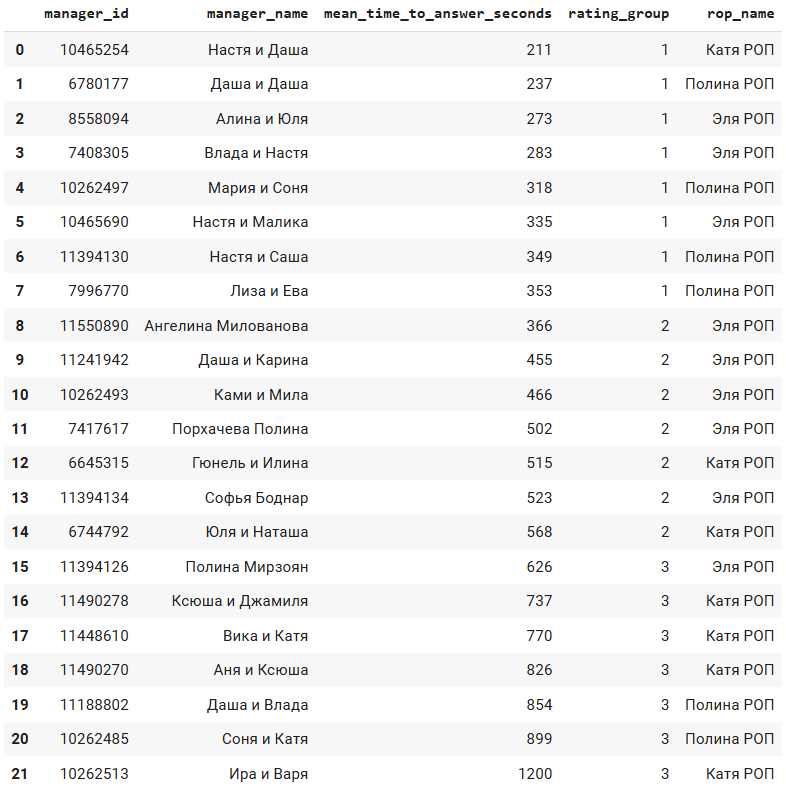

**(8)** Однозначный вывод о том, у какого руководителя менеджеры (пары менеджеров) наиболее быстро отвечают на вопросы клиентов, сделать нельзя. Опираясь на результаты:

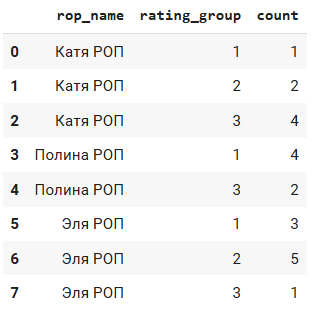

можно предположить, что лучшие показатели у менеджера Полины. Однако, у Полины меньше всего менеджеров, четверо менеджеров (пар менеджеров) из лидирующей 1-й группы занимают в группе соответственно места в начале, в середине и двое в самом конце, а менеджеры (пары менеджеров) из 3-й группы находятся среди самых главных антилидеров.

Соответственно, указанный результат не позволяет дать оценку работы руководителей Отдела продаж, однако на его основе руководители отдела продаж могут уточнить свою работу с менеджерами, обсудить причины долгих ответов на сообщения клиентов и наметить соответствующую программу.


**(9)** По среднему времени ответа на вопрос всех менеджеров, закрепленных за каждым руководителем Отдела продаж, лидирует Эля (среднее время ответа 425 секунд), на втором месте Полина (502 секунды), дольше всего отвечают на вопросы клиентов менеджеры (пары менеджеров) руководителя Кати (690 секунд).

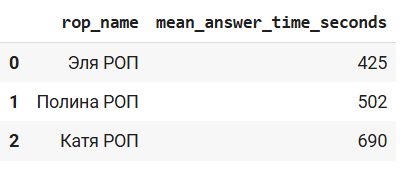